In [677]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [678]:
#get labels
data = pd.read_csv("Datasets/Normalized_CWE-469.csv")
#get embeddings 
x= pd.read_csv("graph2vec/features/embledding_cwe_469.csv")

In [679]:
data["vuln"] = data["vuln"].astype(int)

In [680]:
data.head()

,Unnamed: 0,testID,filename,code,vuln,type
0,0,0,cwe469_0.c,"gretl_list_build (const char *s, const DATASET...",0,CWE-469
1,1,1,cwe469_1.c,rd_meta_is_broken(FILE *fp)\n{\n char buf[M...,1,CWE-469
2,2,2,cwe469_2.c,"load( f_ck_query query_func, t_CKBOOL lazy )\n...",0,CWE-469
3,3,3,cwe469_3.c,checkSupGroups (LDAP * ld)\n{\n LDAPMessage *...,1,CWE-469
4,4,4,cwe469_4.c,"dht_getxattr_unwind (call_frame_t *frame,\n ...",0,CWE-469


In [681]:
indices = x['type'].values
y = data.iloc[:, 4]
y_labels = y.iloc[indices]
y_labels.head()

0       0
1       1
10      0
100     0
1000    1
Name: vuln, dtype: int64

In [682]:
x = x.drop(columns="type")
x.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127
0,-0.086220,-0.183489,-0.311828,0.210561,-0.011794,0.046493,-0.247115,0.002444,-0.054876,0.163939,...,0.136654,0.208798,0.118810,0.194054,0.098417,-0.000896,-0.060261,0.012516,0.089105,-0.105244
1,0.050206,-0.533095,-0.311225,0.058918,-0.018652,-0.024216,-0.350888,-0.090321,0.005125,0.200890,...,0.236584,0.052393,-0.022136,0.186589,0.007961,-0.023393,0.154599,-0.031407,-0.102472,-0.181720
2,-0.023950,-0.167754,-0.200610,0.141800,-0.017827,-0.013925,-0.161392,-0.095699,0.004724,0.130106,...,0.096194,0.076208,0.018431,0.087224,0.073983,-0.024665,-0.001303,-0.029866,0.062740,-0.076197
3,-0.008526,-0.158457,-0.380494,0.172831,0.048501,-0.012732,-0.286329,-0.010031,-0.268125,0.163671,...,0.191623,0.287033,-0.020448,0.148487,0.040430,-0.068902,-0.027892,0.025348,0.106796,-0.069266
4,0.005788,-0.437232,-0.307672,0.062768,-0.005194,-0.015667,-0.310069,-0.057550,-0.023266,0.175896,...,0.232327,0.029678,-0.008981,0.134089,0.028003,-0.011975,0.156055,-0.036535,-0.023201,-0.182217


In [683]:
dataset = pd.concat([x, y_labels], axis=1)

In [684]:
dataset.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,vuln
0,-0.086220,-0.183489,-0.311828,0.210561,-0.011794,0.046493,-0.247115,0.002444,-0.054876,0.163939,...,0.208798,0.118810,0.194054,0.098417,-0.000896,-0.060261,0.012516,0.089105,-0.105244,0
1,0.050206,-0.533095,-0.311225,0.058918,-0.018652,-0.024216,-0.350888,-0.090321,0.005125,0.200890,...,0.052393,-0.022136,0.186589,0.007961,-0.023393,0.154599,-0.031407,-0.102472,-0.181720,1
2,-0.023950,-0.167754,-0.200610,0.141800,-0.017827,-0.013925,-0.161392,-0.095699,0.004724,0.130106,...,0.076208,0.018431,0.087224,0.073983,-0.024665,-0.001303,-0.029866,0.062740,-0.076197,0
3,-0.008526,-0.158457,-0.380494,0.172831,0.048501,-0.012732,-0.286329,-0.010031,-0.268125,0.163671,...,0.287033,-0.020448,0.148487,0.040430,-0.068902,-0.027892,0.025348,0.106796,-0.069266,1
4,0.005788,-0.437232,-0.307672,0.062768,-0.005194,-0.015667,-0.310069,-0.057550,-0.023266,0.175896,...,0.029678,-0.008981,0.134089,0.028003,-0.011975,0.156055,-0.036535,-0.023201,-0.182217,0


In [685]:
example = dataset.iloc[0]
print(example.vuln)

0.0


In [686]:
y = dataset['vuln']

In [687]:
# Splitting the dataset into the Training set and Test set
# Into 80% training and 10% testing and 10% validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [688]:
print("X_train length: ", len(X_train))
print("X_test length: ", len(X_test))
print("X_val length: ", len(X_val))

X_train length:  3150
X_test length:  1050
X_val length:  1050


In [689]:
# Convert to tensor
X_train_tensors = torch.FloatTensor(X_train.values)
X_test_tensors = torch.FloatTensor(X_test.values)
X_val_tensors = torch.FloatTensor(X_val.values)

In [690]:
example = X_train_tensors[0]
print(example)

tensor([-0.1044, -0.2702, -0.3096,  0.2490, -0.0859,  0.0297, -0.2497, -0.1843,
         0.0832,  0.0603, -0.1374,  0.1125,  0.0105, -0.0031,  0.0963, -0.0138,
        -0.0261,  0.1157,  0.0574, -0.1600, -0.1491,  0.1590, -0.0766,  0.0752,
         0.1263, -0.1844, -0.1875, -0.0515,  0.0329, -0.0777, -0.1645,  0.1266,
        -0.1247, -0.0344,  0.1177,  0.0822, -0.0488,  0.0005,  0.0063, -0.1538,
        -0.0468, -0.0274, -0.1140, -0.3691, -0.0045,  0.0276,  0.0470,  0.0532,
         0.0841,  0.0777,  0.1068,  0.0068, -0.1783, -0.0616, -0.0924,  0.0143,
         0.0813, -0.1029,  0.0908, -0.0952, -0.1208,  0.1156, -0.1005,  0.0544,
         0.2751,  0.2337, -0.0875,  0.1567, -0.0253, -0.1685, -0.0343,  0.1071,
        -0.2533, -0.0764, -0.3147, -0.0577, -0.0172, -0.0850, -0.2048, -0.0085,
        -0.0190, -0.0760, -0.2477,  0.1043, -0.0426, -0.0588,  0.0908, -0.0841,
         0.2492,  0.1057, -0.1262,  0.2366, -0.1645, -0.0369, -0.2446, -0.0850,
        -0.0638,  0.0705,  0.0210,  0.10

In [691]:
y_train_tensors = torch.tensor(y_train.values)
y_test_tensors = torch.tensor(y_test.values)
y_val_tensors = torch.tensor(y_val.values)

In [692]:
example = y_train_tensors[399]
print(example)

tensor(1)


In [693]:
# Ensure float tensors
y_train_tensors = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensors = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensors = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
test_dataset = TensorDataset(X_test_tensors, y_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **MLP Model**
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        # self.model = nn.Sequential(
        #     nn.Linear(128, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 1),
        #     nn.Sigmoid()
        # )

    def forward(self, x):
        return self.model(x)

# Initialize Model
input_dim = X_train_tensors.shape[1]
mlp_model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-3)  # Increased LR & weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# **Training Function**
def train():
    mlp_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# **Evaluation Function**
def evaluate(X_tensors, y_tensors):
    mlp_model.eval()
    with torch.no_grad():
        outputs = mlp_model(X_tensors)
        loss = criterion(outputs, y_tensors)
        acc = ((outputs > 0.5) == y_tensors).float().mean().item()
    return acc, loss.item()

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [694]:
# **Training Loop with Early Stopping**
print("Starting training...")
train_losses, val_losses = [], []
val_acc_list, train_acc_list = [], []
best_loss, early_stopping_counter = float("inf"), 0

for epoch in range(200):
    if early_stopping_counter <= 10:  # Increased patience
        train_loss = train()
        train_acc, _ = evaluate(X_train_tensors, y_train_tensors)   
        val_acc, val_loss = evaluate(X_val_tensors, y_val_tensors)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)

        scheduler.step(val_loss)  # Reduce LR on plateau

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0  # Reset counter
        else:
            early_stopping_counter += 1

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Best Val Loss: {best_loss:.4f}")
    else:
        print("Early stopping due to no improvement.")
        break

print(f"Finished training with best validation loss: {best_loss:.4f}")

# **Test Model**
test_acc, test_loss = evaluate(X_test_tensors, y_test_tensors)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Starting training...
Epoch 1 | Train Loss: 0.6966 | Train Acc: 0.5517 | Val Acc: 0.4800 | Best Val Loss: 0.6948
Epoch 2 | Train Loss: 0.6916 | Train Acc: 0.5457 | Val Acc: 0.5019 | Best Val Loss: 0.6948
Epoch 3 | Train Loss: 0.6912 | Train Acc: 0.5425 | Val Acc: 0.4819 | Best Val Loss: 0.6948
Epoch 4 | Train Loss: 0.6909 | Train Acc: 0.5616 | Val Acc: 0.4962 | Best Val Loss: 0.6946
Epoch 5 | Train Loss: 0.6904 | Train Acc: 0.5565 | Val Acc: 0.4914 | Best Val Loss: 0.6946
Epoch 6 | Train Loss: 0.6879 | Train Acc: 0.5581 | Val Acc: 0.4990 | Best Val Loss: 0.6946
Epoch 7 | Train Loss: 0.6887 | Train Acc: 0.5584 | Val Acc: 0.4895 | Best Val Loss: 0.6946
Epoch 8 | Train Loss: 0.6859 | Train Acc: 0.5663 | Val Acc: 0.5067 | Best Val Loss: 0.6946
Epoch 9 | Train Loss: 0.6870 | Train Acc: 0.5670 | Val Acc: 0.4886 | Best Val Loss: 0.6946
Epoch 10 | Train Loss: 0.6861 | Train Acc: 0.5686 | Val Acc: 0.4943 | Best Val Loss: 0.6946
Epoch 11 | Train Loss: 0.6814 | Train Acc: 0.5711 | Val Acc: 0.4952 

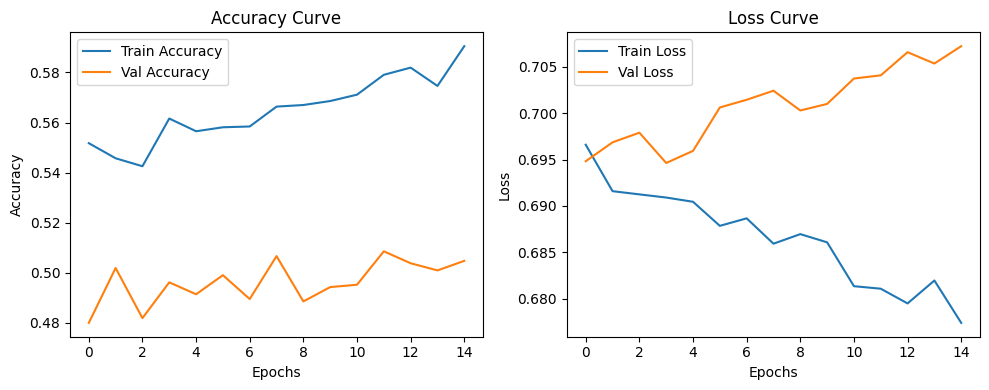

In [695]:
# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [696]:
# Analyze the results
test_batch = next(iter(X_test_tensors))
with torch.no_grad():
    y_pred = mlp_model(X_test_tensors) 
    df = pd.DataFrame()
    df["y_pred"] = y_pred.tolist()
df

,y_pred
0,[0.37740233540534973]
1,[0.47456595301628113]
2,[0.5011778473854065]
3,[0.4802156090736389]
4,[0.4587033987045288]
...,...
1045,[0.4978839159011841]
1046,[0.523547887802124]
1047,[0.4936388432979584]
1048,[0.5141270160675049]


In [697]:
df['y_real'] = y_test_tensors.tolist()
df

,y_pred,y_real
0,[0.37740233540534973],[0.0]
1,[0.47456595301628113],[0.0]
2,[0.5011778473854065],[0.0]
3,[0.4802156090736389],[0.0]
4,[0.4587033987045288],[0.0]
...,...,...
1045,[0.4978839159011841],[1.0]
1046,[0.523547887802124],[0.0]
1047,[0.4936388432979584],[1.0]
1048,[0.5141270160675049],[0.0]


In [698]:
# y_test = y_test_tensors.detach().cpu().numpy()
y_pred = np.rint(y_pred)
# confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(model, x_test_tensors, y_test_tensors)  
# plt.show()
accuracy= accuracy_score(y_test_tensors, y_pred)
precision= precision_score(y_test_tensors, y_pred, zero_division=1)
recall= recall_score(y_test_tensors, y_pred, zero_division=1)
F1= f1_score(y_test_tensors,y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, F1))

 Accuracy : 0.4961904761904762 
 Precision : 0.5128644939965694 
 Recall : 0.5496323529411765 
 F1 : 0.5306122448979592


/var/folders/p4/tbffr9s55dj1cl9_z190r81m0000gn/T/ipykernel_39886/3662197229.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_pred = np.rint(y_pred)


In [699]:
# Print Classification Report
y_pred = (y_pred > 0.5).float()
print(classification_report(y_test_tensors, y_pred))

# Print Confusion Matrix
cm = confusion_matrix(y_test_tensors, y_pred)
print(cm)

# Print Accuracy
accuracy = accuracy_score(y_test_tensors, y_pred)
print(f"Accuracy: {accuracy:.4f}")

              precision    recall  f1-score   support

         0.0       0.48      0.44      0.46       506
         1.0       0.51      0.55      0.53       544

    accuracy                           0.50      1050
   macro avg       0.49      0.49      0.49      1050
weighted avg       0.49      0.50      0.49      1050

[[222 284]
 [245 299]]
Accuracy: 0.4962


In [700]:
# y_test = y_test_tensors.detach().cpu().numpy()
y_pred = np.rint(y_pred)
# confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(model, x_test_tensors, y_test_tensors)  
# plt.show()
accuracy= accuracy_score(y_test_tensors, y_pred)
precision= precision_score(y_test_tensors, y_pred, zero_division=1)
recall= recall_score(y_test_tensors, y_pred, zero_division=1)
F1= f1_score(y_test_tensors,y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, F1))

 Accuracy : 0.4961904761904762 
 Precision : 0.5128644939965694 
 Recall : 0.5496323529411765 
 F1 : 0.5306122448979592


/var/folders/p4/tbffr9s55dj1cl9_z190r81m0000gn/T/ipykernel_39886/3662197229.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_pred = np.rint(y_pred)


In [701]:
mlp_model.eval()
y_pred = mlp_model(X_test_tensors)
after_train = criterion(y_pred.squeeze(), y_test_tensors.float())
print('Test loss after training' , after_train.item())

ValueError: Using a target size (torch.Size([1050, 1])) that is different to the input size (torch.Size([1050])) is deprecated. Please ensure they have the same size.